# 📥 Importing Libraries...

In [1]:
import os
import warnings
import time
import pickle
import joblib

# 📊 Data Manipulation & Visualization
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# ⚙️ Sklearn - Model Selection & Metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score

# ⚙️ Sklearn - Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, RandomForestRegressor

# ⚙️ Sklearn - Imputation
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

# ⚖️ Imbalanced Data Handling
from imblearn.over_sampling import SMOTE

# 🧠 Deep Learning - TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential  # type: ignore
from tensorflow.keras.layers import Dense, Dropout  # type: ignore

# 📈 Gradient Boosting Models
from xgboost import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

# 🔇 Global Warning Config
warnings.filterwarnings("ignore")
os.environ['PYTHONWARNINGS'] = 'ignore'

# 🧾 Pandas Display Options
pd.set_option('display.max_columns', None)


# 📂 Loading the dataset

In [2]:
weather_df = pd.read_csv("weatherAUS.csv")

# 📋 Dataset Overview & Missing Value Analysis

In [3]:
# 👀 Preview the first 5 rows of the dataset
weather_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [4]:
# 🗓️ Remove 'Date' column (not useful for ML)
weather_df.drop(columns=["Date"], inplace=True, errors='ignore')

In [5]:
# 🔢 Shape of the dataset (rows, columns)
weather_df.shape

(142193, 23)

In [6]:
# 🧾 Dataset information: data types, non-null counts
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       142193 non-null  object 
 1   MinTemp        141556 non-null  float64
 2   MaxTemp        141871 non-null  float64
 3   Rainfall       140787 non-null  float64
 4   Evaporation    81350 non-null   float64
 5   Sunshine       74377 non-null   float64
 6   WindGustDir    132863 non-null  object 
 7   WindGustSpeed  132923 non-null  float64
 8   WindDir9am     132180 non-null  object 
 9   WindDir3pm     138415 non-null  object 
 10  WindSpeed9am   140845 non-null  float64
 11  WindSpeed3pm   139563 non-null  float64
 12  Humidity9am    140419 non-null  float64
 13  Humidity3pm    138583 non-null  float64
 14  Pressure9am    128179 non-null  float64
 15  Pressure3pm    128212 non-null  float64
 16  Cloud9am       88536 non-null   float64
 17  Cloud3pm       85099 non-null

In [7]:
# 🧼 Strip whitespace from all object (string) columns
for col in weather_df.select_dtypes(include='object').columns:
    weather_df[col] = weather_df[col].str.strip()

In [8]:
# 📊 Summary statistics of numerical features
weather_df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000,142193.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235,2.360682
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594,8.477969
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.800000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,371.000000


In [9]:
# 🕳️ Percentage of missing values in each column
(weather_df.isnull().sum() / weather_df.count()) * 100

Location          0.000000
MinTemp           0.449999
MaxTemp           0.226967
Rainfall          0.998672
Evaporation      74.791641
Sunshine         91.178725
WindGustDir       7.022271
WindGustSpeed     6.973962
WindDir9am        7.575276
WindDir3pm        2.729473
WindSpeed9am      0.957080
WindSpeed3pm      1.884454
Humidity9am       1.263362
Humidity3pm       2.604937
Pressure9am      10.933148
Pressure3pm      10.904596
Cloud9am         60.604726
Cloud3pm         67.091270
Temp9am           0.639823
Temp3pm           1.954584
RainToday         0.998672
RISK_MM           0.000000
RainTomorrow      0.000000
dtype: float64

# 🔍 Feature Engineering and Handling Missing Values

In [10]:
# 🚮 Drop columns with more than 60% missing values
missing_cols = ((weather_df.isnull().sum()) / weather_df.count() * 100).loc[lambda x: x > 60].index.tolist()
weather_df.drop(missing_cols, axis=1, inplace=True)

# 🔻 Drop rows where 'RainToday' is missing (needed for target encoding)
weather_df.dropna(subset=['RainToday'], inplace=True)


In [11]:
# 🌧️ Encode 'RainToday': Yes → 1, No → 0
weather_df['RainToday'] = weather_df['RainToday'].map({'Yes': 1, 'No': 0})

# 🌦️ Encode 'RainTomorrow': Yes → 1, No → 0
weather_df['RainTomorrow'] = weather_df['RainTomorrow'].map({'Yes': 1, 'No': 0})

In [12]:
df_imputed = weather_df.copy()
wind_direction_angle = {
    'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5, 'E': 90, 'ESE': 112.5,
    'SE': 135, 'SSE': 157.5, 'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
    'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
}
for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    angles = df_imputed[col].map(wind_direction_angle)
    df_imputed[col] = np.sin(np.radians(angles)) + np.cos(np.radians(angles))
df_imputed.drop(columns=['Location', 'RainToday','RainTomorrow','RISK_MM'], inplace=True)

# !! This imputation is allready done and saved in CSV File. Skip to the next step

In [ ]:
imputer = IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1, random_state=42),max_iter=20, tol=0.1, random_state=0)
df_imputed_imputed = pd.DataFrame(imputer.fit_transform(df_imputed), columns=df_imputed.columns)
df_final = pd.concat([weather_df[['Location','RainToday','RainTomorrow','RISK_MM']].reset_index(drop=True),
                      df_imputed_imputed.reset_index(drop=True)], axis=1)
df_final.to_csv("data_imputed.csv", index=False)
print("✅ Imputation complete. Data saved to 'data_imputed.csv'")

# 📂 Reload and Continue...

In [14]:
del weather_df
weather_df = pd.read_csv('data_imputed.csv')

In [15]:
# 🕳️ Percentage of missing values in each column
(weather_df.isnull().sum() / weather_df.count()) * 100

Location         0.0
RainToday        0.0
RainTomorrow     0.0
RISK_MM          0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Temp9am          0.0
Temp3pm          0.0
dtype: float64

In [16]:
weather_df.describe()

,RainToday,RainTomorrow,RISK_MM,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm
count,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,1.407870e+05,140787.000000,1.407870e+05,1.407870e+05,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000
mean,0.223423,0.221618,2.313202,12.185840,23.236785,2.349974,-6.495410e-02,39.727960,3.687649e-02,-6.000787e-02,13.912129,18.507402,68.901810,51.516337,1017.739800,1015.333494,16.966011,21.727961
std,0.416541,0.415337,8.334842,6.399073,7.112971,8.465173,9.780981e-01,13.549786,9.576007e-01,9.785775e-01,8.913080,8.854068,19.032159,20.752917,6.824514,6.738488,6.507065,6.971906
min,0.000000,0.000000,0.000000,-8.500000,-4.800000,0.000000,-1.414214e+00,6.000000,-1.414214e+00,-1.414214e+00,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,-7.200000,-5.400000
25%,0.000000,0.000000,0.000000,7.600000,17.900000,0.000000,-1.000000e+00,30.000000,-1.000000e+00,-1.000000e+00,7.000000,13.000000,57.000000,37.000000,1013.400000,1011.000000,12.200000,16.600000
50%,0.000000,0.000000,0.000000,12.000000,22.600000,0.000000,-3.330669e-16,37.390000,1.110223e-16,-3.330669e-16,13.000000,17.000000,70.000000,52.000000,1017.800000,1015.400000,16.700000,21.100000
75%,0.000000,0.000000,0.600000,16.800000,28.200000,0.800000,1.000000e+00,48.000000,1.000000e+00,1.000000e+00,19.000000,24.000000,83.000000,66.000000,1022.100000,1019.600000,21.582000,26.500000
max,1.000000,1.000000,371.000000,33.900000,48.100000,371.000000,1.414214e+00,135.000000,1.414214e+00,1.414214e+00,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,40.200000,46.700000


# 🔍 Outlier Detection

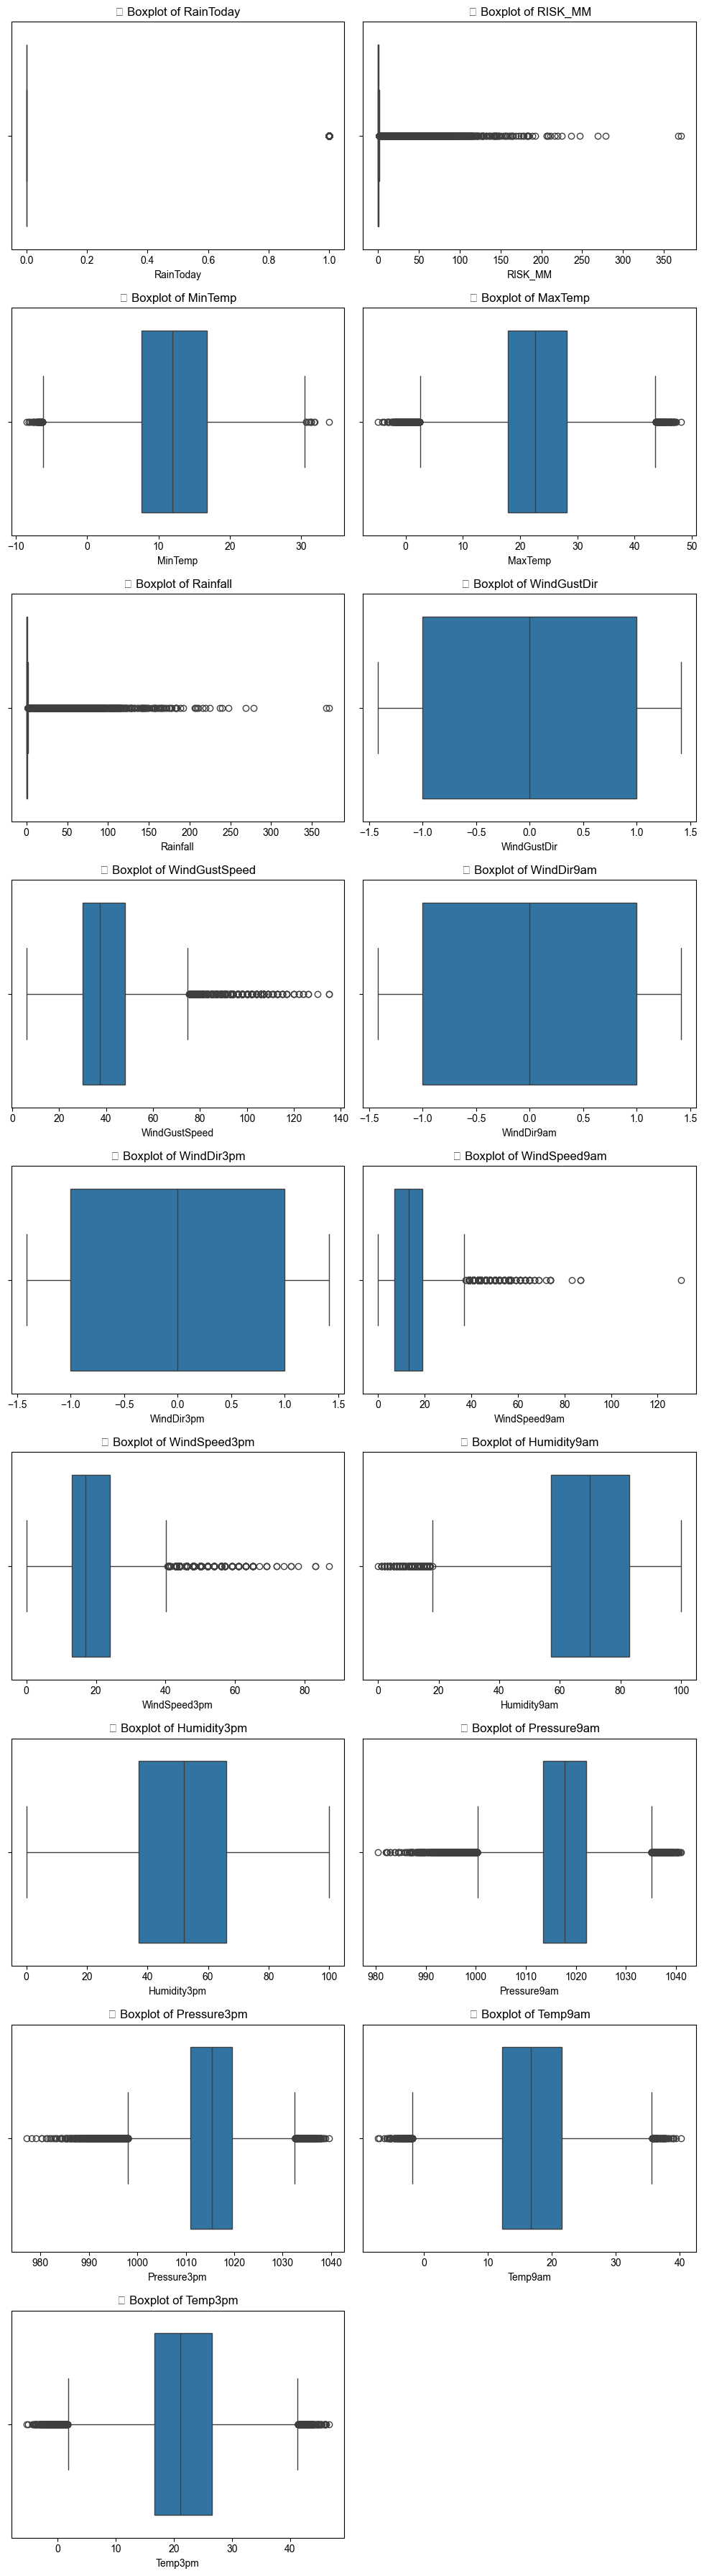

In [17]:
# 📊 Step 1: Identify numeric columns (excluding target variable)
numeric_cols = weather_df.select_dtypes(include=[np.number]).columns.tolist()
if 'RainTomorrow' in numeric_cols:
    numeric_cols.remove('RainTomorrow')  # 🚫 Exclude target

# 🧹 Step 2: Function to detect outliers using IQR 
def get_outliers_iqr(df, columns):
    outliers_dict = {}
    for col in columns:
        # 🧮 Calculate IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # 🔍 Find outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_dict[col] = outliers
    return outliers_dict

# 📦 Step 3: Store outliers in a dictionary
outliers_features = get_outliers_iqr(weather_df, numeric_cols)

# 📸 Step 4: Visualize outliers with boxplots (side-by-side layout)
import math

cols_per_row = 2  # 🔲 Number of boxplots per row
total_plots = len(numeric_cols)
rows = math.ceil(total_plots / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(10, 4 * rows))
axes = axes.flatten()

sns.set_theme(style='whitegrid')

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=weather_df[col], ax=axes[i], orient='h')
    axes[i].set_title(f"📦 Boxplot of {col}")
    axes[i].set_xlabel(col)

# Turn off unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 🧪 Outlier Handling...

In [18]:
numeric_cols = weather_df.select_dtypes(include=[np.number]).columns.tolist()
for col in ['RainTomorrow', 'RainToday']:
    if col in numeric_cols:
        numeric_cols.remove(col)
def handle_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower_bound, upper_bound)
    return df
weather_df = handle_outliers_iqr(weather_df, numeric_cols)



# 🧮 Compute correlation matrix 

In [19]:
numeric_cols = weather_df.select_dtypes(include=[np.number]).columns.tolist()

In [20]:
weather_df.describe()

,RainToday,RainTomorrow,RISK_MM,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm
count,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,1.407870e+05,140787.000000,1.407870e+05,1.407870e+05,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000
mean,0.223423,0.221618,0.386339,12.186015,23.239660,0.485723,-6.495410e-02,39.569823,3.687649e-02,-6.000787e-02,13.823460,18.420727,68.955079,51.516337,1017.765999,1015.351904,16.966937,21.730969
std,0.416541,0.415337,0.610542,6.398156,7.096274,0.791851,9.780981e-01,13.030147,9.576007e-01,9.785775e-01,8.615736,8.582014,18.877999,20.752917,6.697309,6.626691,6.500482,6.947478
min,0.000000,0.000000,0.000000,-6.200000,2.450000,0.000000,-1.414214e+00,6.000000,-1.414214e+00,-1.414214e+00,0.000000,0.000000,18.000000,0.000000,1000.350000,998.100000,-1.873000,1.750000
25%,0.000000,0.000000,0.000000,7.600000,17.900000,0.000000,-1.000000e+00,30.000000,-1.000000e+00,-1.000000e+00,7.000000,13.000000,57.000000,37.000000,1013.400000,1011.000000,12.200000,16.600000
50%,0.000000,0.000000,0.000000,12.000000,22.600000,0.000000,-3.330669e-16,37.390000,1.110223e-16,-3.330669e-16,13.000000,17.000000,70.000000,52.000000,1017.800000,1015.400000,16.700000,21.100000
75%,0.000000,0.000000,0.600000,16.800000,28.200000,0.800000,1.000000e+00,48.000000,1.000000e+00,1.000000e+00,19.000000,24.000000,83.000000,66.000000,1022.100000,1019.600000,21.582000,26.500000
max,1.000000,1.000000,1.500000,30.600000,43.650000,2.000000,1.414214e+00,75.000000,1.414214e+00,1.414214e+00,37.000000,40.500000,100.000000,100.000000,1035.150000,1032.500000,35.655000,41.350000


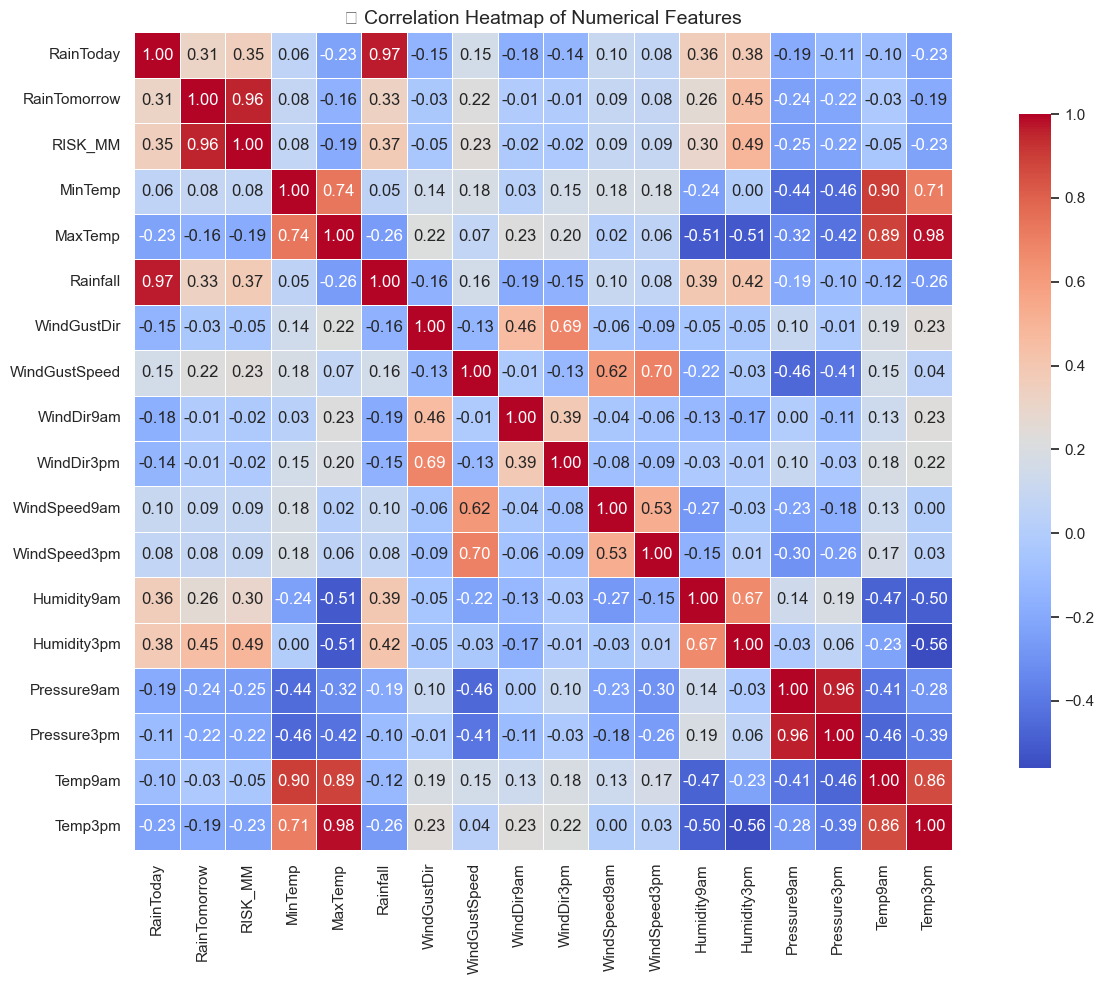

In [21]:
corr_matrix = weather_df[numeric_cols].corr()

# 🎨 Plot the heatmap
plt.figure(figsize=(14, 10))
sns.set_theme(style="white")

heatmap = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
                      linewidths=0.5, square=True, cbar_kws={"shrink": .8})

plt.title("📊 Correlation Heatmap of Numerical Features", fontsize=14)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [22]:
# 🧹 Droping column
weather_df.drop(['RISK_MM'], axis=1, inplace=True)


We have dropped the feature Risk_MM from the dataset because it is highly correlated with the target variable RainTomorrow. Keeping this feature would risk data leakage, as it contains information that is too closely tied to the outcome we are trying to predict.

Just because variables are highly correlated doesn't mean they're not important — especially in weather prediction, where:

🌡️ Temp3pm captures peak daily temperature — key for predicting rain

🧊 Pressure9am and Pressure3pm indicate pressure drops — often signaling upcoming rain

☀️ Temp9am shows morning trends — relevant for early rain patterns

In [23]:
# 🧬 Encoding Categorical Features...
weather_df = pd.concat([weather_df, pd.get_dummies(weather_df.Location, dtype=int)], axis=1)
weather_df.drop(['Location'], axis=1, inplace=True)

In [24]:
# 🧾 Feature-Target Separation...
X = weather_df.drop('RainTomorrow', axis=1)
y = weather_df['RainTomorrow']

# ⚖️ Balancing Dataset with SMOTE...
X_balanced, y_balanced = SMOTE(random_state=42).fit_resample(X, y)

model_columns = X.columns

# Ensure the column names are preserved after resampling
X_balanced = pd.DataFrame(X_balanced, columns=model_columns)

# ✂️ Train-Validation-Test Split...
X_train, X_temp, y_train, y_temp = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 🚀 Model Training & Evaluation

In [25]:
# 🤖 Training Traditional ML Models
accuracy_dict = {}
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "K-Nearest Neighbors": KNeighborsClassifier(n_jobs=-1),
    "Decision Tree": DecisionTreeClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Random Forest": RandomForestClassifier(n_jobs=-1)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = round(accuracy_score(y_val, y_pred) * 100, 2)
    accuracy_dict[name] = accuracy
    print(f"\n{name} Classification Report")
    print(f"The classification accuracy is {accuracy}%")
    print(classification_report(y_val, y_pred, target_names=["Not Rain", "Rain"]))

# ⚡️ Training GPU XGBoost Model
xgb_model = xgb.XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    random_state=144,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_val)
xgb_accuracy = round(accuracy_score(y_val, xgb_pred) * 100, 2)
accuracy_dict['XGBoost (GPU)'] = xgb_accuracy
print(f"\nXGBoost (GPU) Classification Report")
print(f"The classification accuracy is {xgb_accuracy}%")
print(classification_report(y_val, xgb_pred, target_names=["Not Rain", "Rain"]))

# 🧠 Training Deep Learning Model
Seq_model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

Seq_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
hist = Seq_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=100, verbose=1)
Seq_model_accuracy = round(Seq_model.evaluate(X_val, y_val)[1] * 100, 2)
accuracy_dict['Deep Sequential'] = Seq_model_accuracy
print(f"\nThe classification accuracy of Deep Sequential model is {Seq_model_accuracy}%")


Logistic Regression Classification Report
The classification accuracy is 83.0%
              precision    recall  f1-score   support

    Not Rain       0.81      0.85      0.83     16451
        Rain       0.85      0.81      0.83     16425

    accuracy                           0.83     32876
   macro avg       0.83      0.83      0.83     32876
weighted avg       0.83      0.83      0.83     32876


K-Nearest Neighbors Classification Report
The classification accuracy is 84.45%
              precision    recall  f1-score   support

    Not Rain       0.93      0.74      0.83     16451
        Rain       0.79      0.95      0.86     16425

    accuracy                           0.84     32876
   macro avg       0.86      0.84      0.84     32876
weighted avg       0.86      0.84      0.84     32876


Decision Tree Classification Report
The classification accuracy is 84.66%
              precision    recall  f1-score   support

    Not Rain       0.85      0.84      0.85     16451
 

In [26]:
# 📊 Accuracy Summary...
print("\n📊 Classification Accuracy of All Models:")
for model_name, acc in accuracy_dict.items():
    print(f"{model_name:<20} = {acc:.2f} %")


📊 Classification Accuracy of All Models:
Logistic Regression  = 83.00 %
K-Nearest Neighbors  = 84.45 %
Decision Tree        = 84.66 %
AdaBoost             = 79.75 %
Random Forest        = 90.45 %
XGBoost (GPU)        = 90.76 %
Deep Sequential      = 85.38 %


# 🛠️ Hyperparameter Tuning for Optimized Performance

In [27]:
# Base model with GPU settings
xgb_model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=0,
    n_jobs=-1
)

# Hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Randomized search with GPU
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                    # You can increase this
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 🔁 Fit the model and measure time
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

# 🎯 Best Model
best_xgb_gpu = random_search.best_estimator_
best_params_xgb = random_search.best_params_
y_pred = best_xgb_gpu.predict(X_val)
acc = accuracy_score(y_val, y_pred)

# 🖨️ Output
print("\n✅ Best Parameters:", best_params_xgb)
print("🎯 Accuracy on Validation Set: {:.2f}%".format(acc * 100))
print("\n📊 Classification Report:\n", classification_report(y_val, y_pred))
print("⏱️ Total Time: {:.2f} seconds".format(end_time - start_time))


Fitting 3 folds for each of 50 candidates, totalling 150 fits

✅ Best Parameters: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 1, 'colsample_bytree': 0.6}
🎯 Accuracy on Validation Set: 90.82%

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91     16451
           1       0.93      0.88      0.91     16425

    accuracy                           0.91     32876
   macro avg       0.91      0.91      0.91     32876
weighted avg       0.91      0.91      0.91     32876

⏱️ Total Time: 216.86 seconds


In [28]:
cat = CatBoostClassifier(verbose=0, random_state=42)

param_dist = {
    'iterations': [300, 500, 700],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

random_search = RandomizedSearchCV(
    cat,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

best_cat_params = random_search.best_params_
print("✅ Best CatBoost Parameters:", best_cat_params)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
✅ Best CatBoost Parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 7, 'iterations': 700, 'depth': 10}


In [29]:
# ⚙️ Use best parameters if you have
# best_params from XGBoost and best_cat_params from CatBoost tuning assumed available
xgb_model = xgb.XGBClassifier(**best_params_xgb, use_label_encoder=False, eval_metric='logloss')
cat_model = CatBoostClassifier(**best_cat_params, verbose=0)
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, n_jobs=-1)

# 📚 Build Stacking Classifier
stacking_custom = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('cat', cat_model)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    n_jobs=-1
)

# 🧠 Train Model
stacking_custom.fit(X_train, y_train)

# 🎯 Predict
y_pred = stacking_custom.predict(X_test)
y_proba = stacking_custom.predict_proba(X_test)[:, 1]  # Needed for ROC-AUC

# ✅ Evaluation Metrics
accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f"📈 Accuracy: {accuracy}%")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Rain", "Rain"]))

📈 Accuracy: 91.1%

📊 Classification Report:
              precision    recall  f1-score   support

    Not Rain       0.89      0.93      0.91     16275
        Rain       0.93      0.89      0.91     16601

    accuracy                           0.91     32876
   macro avg       0.91      0.91      0.91     32876
weighted avg       0.91      0.91      0.91     32876



## 📊 Confusion Matrix

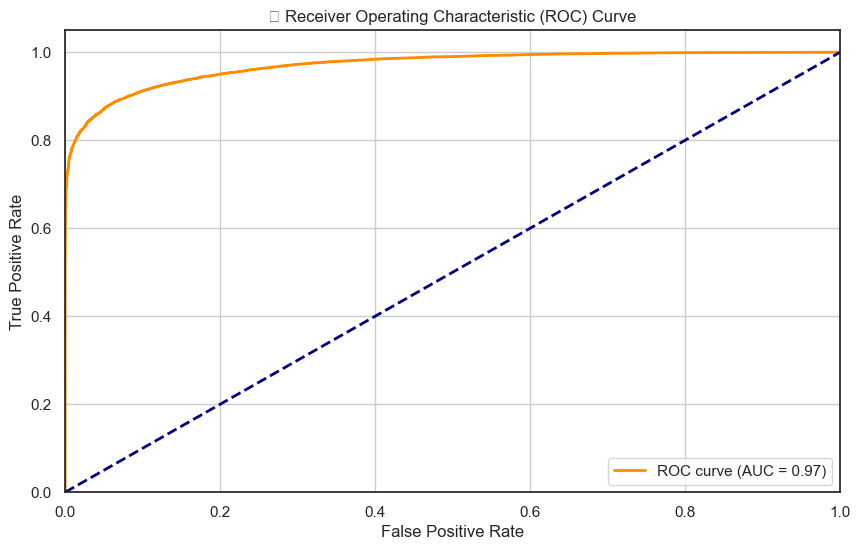

In [30]:
# 📈 ROC-AUC Plot
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📉 Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## 💾 Saving the Final Stacking Model

In [31]:
# 📦 Save the Stacking Model
joblib.dump(stacking_custom, 'stacking_custom.joblib', compress=True)

# 📑 Save the Model Columns
with open('model_columns.pkl', 'wb') as f:
    pickle.dump(model_columns, f)